# Machine Learning

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
# ML functions

def XGB_train(training_end):

    # short cleaning
    df_x = df4.copy()
    df_x.reset_index(inplace=True)
    df_x.drop(columns=["company", "sector", "subsector"], inplace=True)
    df_x["date"] = pd.to_datetime(df_x["date"])
    df_x.set_index("date", inplace=True)
    df_x.sort_index(inplace=True)

    # training with data only until training_end
    xg_df = df_x.loc[:str(training_end+1)]

    # X y split
    X = xg_df.drop(columns="price_30d")
    y = xg_df["price_30d"]

    # normalization
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # train model
    xgbr = xgb.XGBRFRegressor()
    xgbr.fit(X_scaled, y)

    return xgbr

def model_test(year, model):
    df = df4.copy()
    df.reset_index(inplace=True)
    df.drop(columns=["company", "sector", "subsector"], inplace=True)
    df["date"] = pd.to_datetime(df["date"])

    df.set_index("date", inplace=True)
    df.sort_index(inplace=True)
    df = df.loc[(str(year))]
    
    X = df.drop(columns="price_30d")
    y = df["price_30d"]

    # normalization
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    pred = model.predict(X_scaled)

    # metrics
    r2_boost = r2_score(y, pred)
    RMSE_boost = mean_squared_error(y, pred, squared=False)
    MSE_boost = mean_squared_error(y, pred)
    MAE_boost = mean_absolute_error(y, pred)
    print("R2 = ", round(r2_boost, 4))
    print("RMSE = ", round(RMSE_boost, 4))
    print("MSE = ", round(MSE_boost, 4))
    print("MAE = ", round(MAE_boost, 4))

def get_gains(dict_name, model_name):

    """
    Output: monthly gains for the whole year
    """

    df_ga = df4.copy()
    df_ga.reset_index(inplace=True)
    gains_df = pd.DataFrame(columns=["month", "gain"])
    df_ga.drop(columns=["sector", "subsector"], inplace=True)
    df_ga["date"] = pd.to_datetime(df_ga["date"])
    df_ga.set_index("date", inplace=True)    
    for k, v in dict_name.items():
        xg_df = df_ga.loc[v]
        X = xg_df.drop(columns=["price_30d", "company"])
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        pred_xgb = model_name.predict(X_scaled)
        test = xg_df[["close", "price_30d", "company"]]
        test["prediction"] = pred_xgb
        test["gain_predicted"] = (test["prediction"] - test["close"]) / test["close"] * 100
        test["gain_real"] = (test["price_30d"] - test["close"]) / test["close"] * 100

        test.sort_values(by="gain_predicted", ascending=False, inplace=True)
        gain = test.head(10)["gain_real"].mean()

        my_df = pd.DataFrame({"month": [k], "gain": [gain]})

        gains_df = pd.concat([gains_df, my_df], ignore_index=True)

    return gains_df


def create_ML1_df(df):

    """ creates dataframe for machine learning prediction"""

    caps_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/caps_df.csv')
    sector_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/sector_df.csv')

    # add information of marketcap and (sub)sectors
    df = df.merge(caps_df, how="inner", on="company")
    df = df.merge(sector_df, how="inner", on="company")
    df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)

    # data cleaning
    df.columns = [columns.lower().replace(" ", "_") for columns in df.columns]
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df["marketcap"] = df["marketcap"].map(lambda x: x.replace("B", "").replace(",", ""))
    df["marketcap"] = df["marketcap"].map(lambda x: pd.to_numeric(x))

    # moving average, bollinger bands, price change, RSI
    grouped_df = df.groupby("company")

    def ma_bb(company):
        company = company.sort_values(by="date").set_index("date")

        # indicators
        company["ma_20"] = company["close"].rolling(window=20).mean()
        company["ma_60"] = company["close"].rolling(window=60).mean()
        company["bb_lower"] = company["close"].rolling(window=20).mean() - company["close"].rolling(window=20).std()*2
        company["bb_upper"] = company["close"].rolling(window=20).mean() + company["close"].rolling(window=20).std()*2

        company["price_change"] = company["close"].diff()

        company["gain_14"] = company["price_change"].clip(lower=0).rolling(window=14).mean()
        company["loss_14"] = company["price_change"].clip(upper=0).rolling(window=14).mean()

        company["rsi"] = 100 - (100 / (1 + (company["gain_14"] / abs(company["loss_14"]))))
        company["rsi_14"] = company["rsi"].rolling(window=14).mean()

        company["ema_12"] = company["close"].ewm(span=12, adjust=False).mean()
        company["ema_26"] = company["close"].ewm(span=26, adjust=False).mean()
        company["macd"] = (company["ema_12"] - company["ema_26"]).ewm(span=9, adjust=False).mean()


        # lagged indicators
        company["rsi_lag_5"] = company["rsi_14"].shift(5)
        company["rsi_lag_10"] = company["rsi_14"].shift(10)

        # target
        #company["price_30d"] = company["close"].shift(-30)

        return company

    df2 = grouped_df.apply(ma_bb).dropna()

    # dropping not needed price features
    df3 = df2.copy()
    df3.drop(columns=["open", "high", "low"], inplace=True)

    df3.drop(columns="company", inplace=True)
    df3.reset_index(inplace=True)
    df3.set_index("date", inplace=True)

    #df3.to_csv("ml1.csv")
    return df3


def create_ML1_df_training(df):

    """ creates dataframe for machine learning training"""

    # import data
    #df = pd.read_csv("master1.csv")
    caps_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/caps_df.csv')
    sector_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/sector_df.csv')

    # add information of marketcap and (sub)sectors
    df = df.merge(caps_df, how="inner", on="company")
    df = df.merge(sector_df, how="inner", on="company")
    df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)

    # data cleaning
    df.columns = [columns.lower().replace(" ", "_") for columns in df.columns]
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df["marketcap"] = df["marketcap"].map(lambda x: x.replace("B", "").replace(",", ""))
    df["marketcap"] = df["marketcap"].map(lambda x: pd.to_numeric(x))

    # moving average, bollinger bands, price change, RSI
    grouped_df = df.groupby("company")

    def ma_bb(company):
        company = company.sort_values(by="date").set_index("date")

        # indicators
        company["ma_20"] = company["close"].rolling(window=20).mean()
        company["ma_60"] = company["close"].rolling(window=60).mean()
        company["bb_lower"] = company["close"].rolling(window=20).mean() - company["close"].rolling(window=20).std()*2
        company["bb_upper"] = company["close"].rolling(window=20).mean() + company["close"].rolling(window=20).std()*2

        company["price_change"] = company["close"].diff()

        company["gain_14"] = company["price_change"].clip(lower=0).rolling(window=14).mean()
        company["loss_14"] = company["price_change"].clip(upper=0).rolling(window=14).mean()

        company["rsi"] = 100 - (100 / (1 + (company["gain_14"] / abs(company["loss_14"]))))
        company["rsi_14"] = company["rsi"].rolling(window=14).mean()

        company["ema_12"] = company["close"].ewm(span=12, adjust=False).mean()
        company["ema_26"] = company["close"].ewm(span=26, adjust=False).mean()
        company["macd"] = (company["ema_12"] - company["ema_26"]).ewm(span=9, adjust=False).mean()


        # lagged indicators
        company["rsi_lag_5"] = company["rsi_14"].shift(5)
        company["rsi_lag_10"] = company["rsi_14"].shift(10)

        # target
        company["price_30d"] = company["close"].shift(-30)

        return company

    df2 = grouped_df.apply(ma_bb).dropna()

    # dropping not needed price features
    df3 = df2.copy()
    df3.drop(columns=["open", "high", "low"], inplace=True)

    df3.drop(columns="company", inplace=True)
    df3.reset_index(inplace=True)
    df3.set_index("date", inplace=True)

    #df3.to_csv("ml1_training.csv")

    return df3

## Adding Indicators
### Moving Average
Average of last 20 / days for short term and long term

---

### Bollinger Bands
2 Std over / under moving average of 20 days

---

### RSI
- 14 days normally
- RSI = 100 - (100/(1+RS))
- RS = average gain / average loss
- average gained / n of days

---

### EMA
- multiplier: 2 / total_observations+1
- --> for 12 days moving average its 12, multiplier = 2/13
- EMA = (closing price x multiplier) + (previous day EMA x (1 - multiplier))

---

### MACD
- 12 and 26 days EMA
- EMA_12 - EMA_26
- as 9 days EMA

In [3]:
df = pd.read_csv("master1.csv")

In [4]:
df4 = create_ML1_df_training(df)

In [5]:
# import data
#df4 = pd.read_csv("ml1.csv")

## Plots

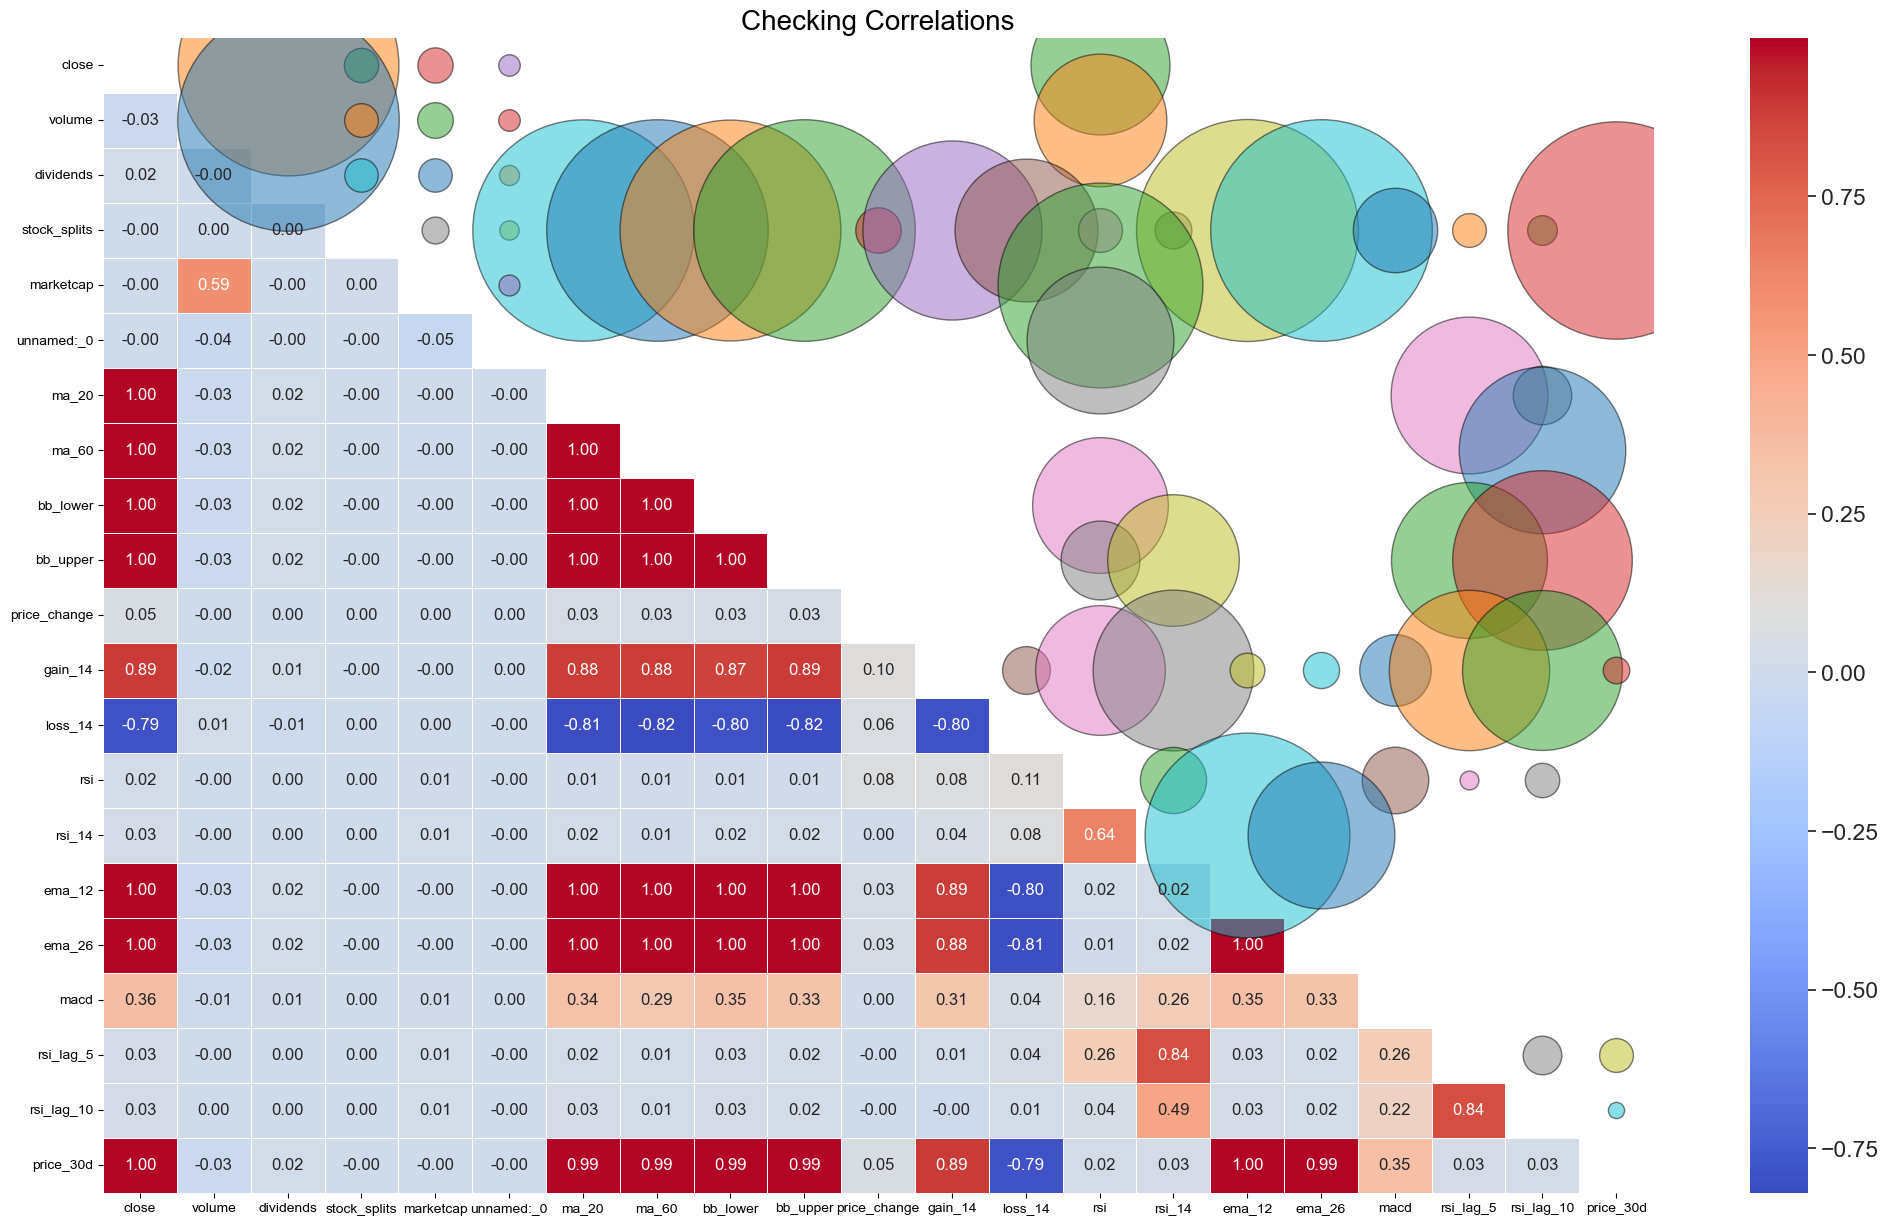

In [6]:
# funny looking correlation heat map

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

# Sample DataFrame
num = df4.select_dtypes(include=[np.number])
correlation_matrix = num.corr()

# Function to calculate p-values
def calculate_p_values(df):
    df_cols = pd.DataFrame(columns=df.columns)
    p_values = df_cols.transpose().join(df_cols, how='outer')
    
    for r in df.columns:
        for c in df.columns:
            if r == c:
                p_values[r][c] = np.nan
            else:
                _, p_value = pearsonr(df[r], df[c])
                p_values[r][c] = p_value
    return p_values

p_values = calculate_p_values(num)

# Create masks for the lower and upper triangles
mask_corr = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5)

# Heat map for lower triangle
sns.heatmap(
    correlation_matrix, 
    mask=mask_corr, 
    annot=True, 
    annot_kws={"size": 12}, 
    linewidths=.5, 
    cmap="coolwarm", 
    fmt=".2f", 
    ax=ax
)

# Overlay bubbles for p-values in the upper triangle
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        p_val = p_values.iloc[i, j]
        bubble_size = -np.log10(p_val) * 100 if p_val > 0 else 0
        ax.scatter(j + 0.5, i + 0.5, s=bubble_size, edgecolors='black', alpha=0.5)

ax.set_title("Checking Correlations", fontsize=20)

plt.show()

Text(0.5, 1.0, 'Checking Correlations')

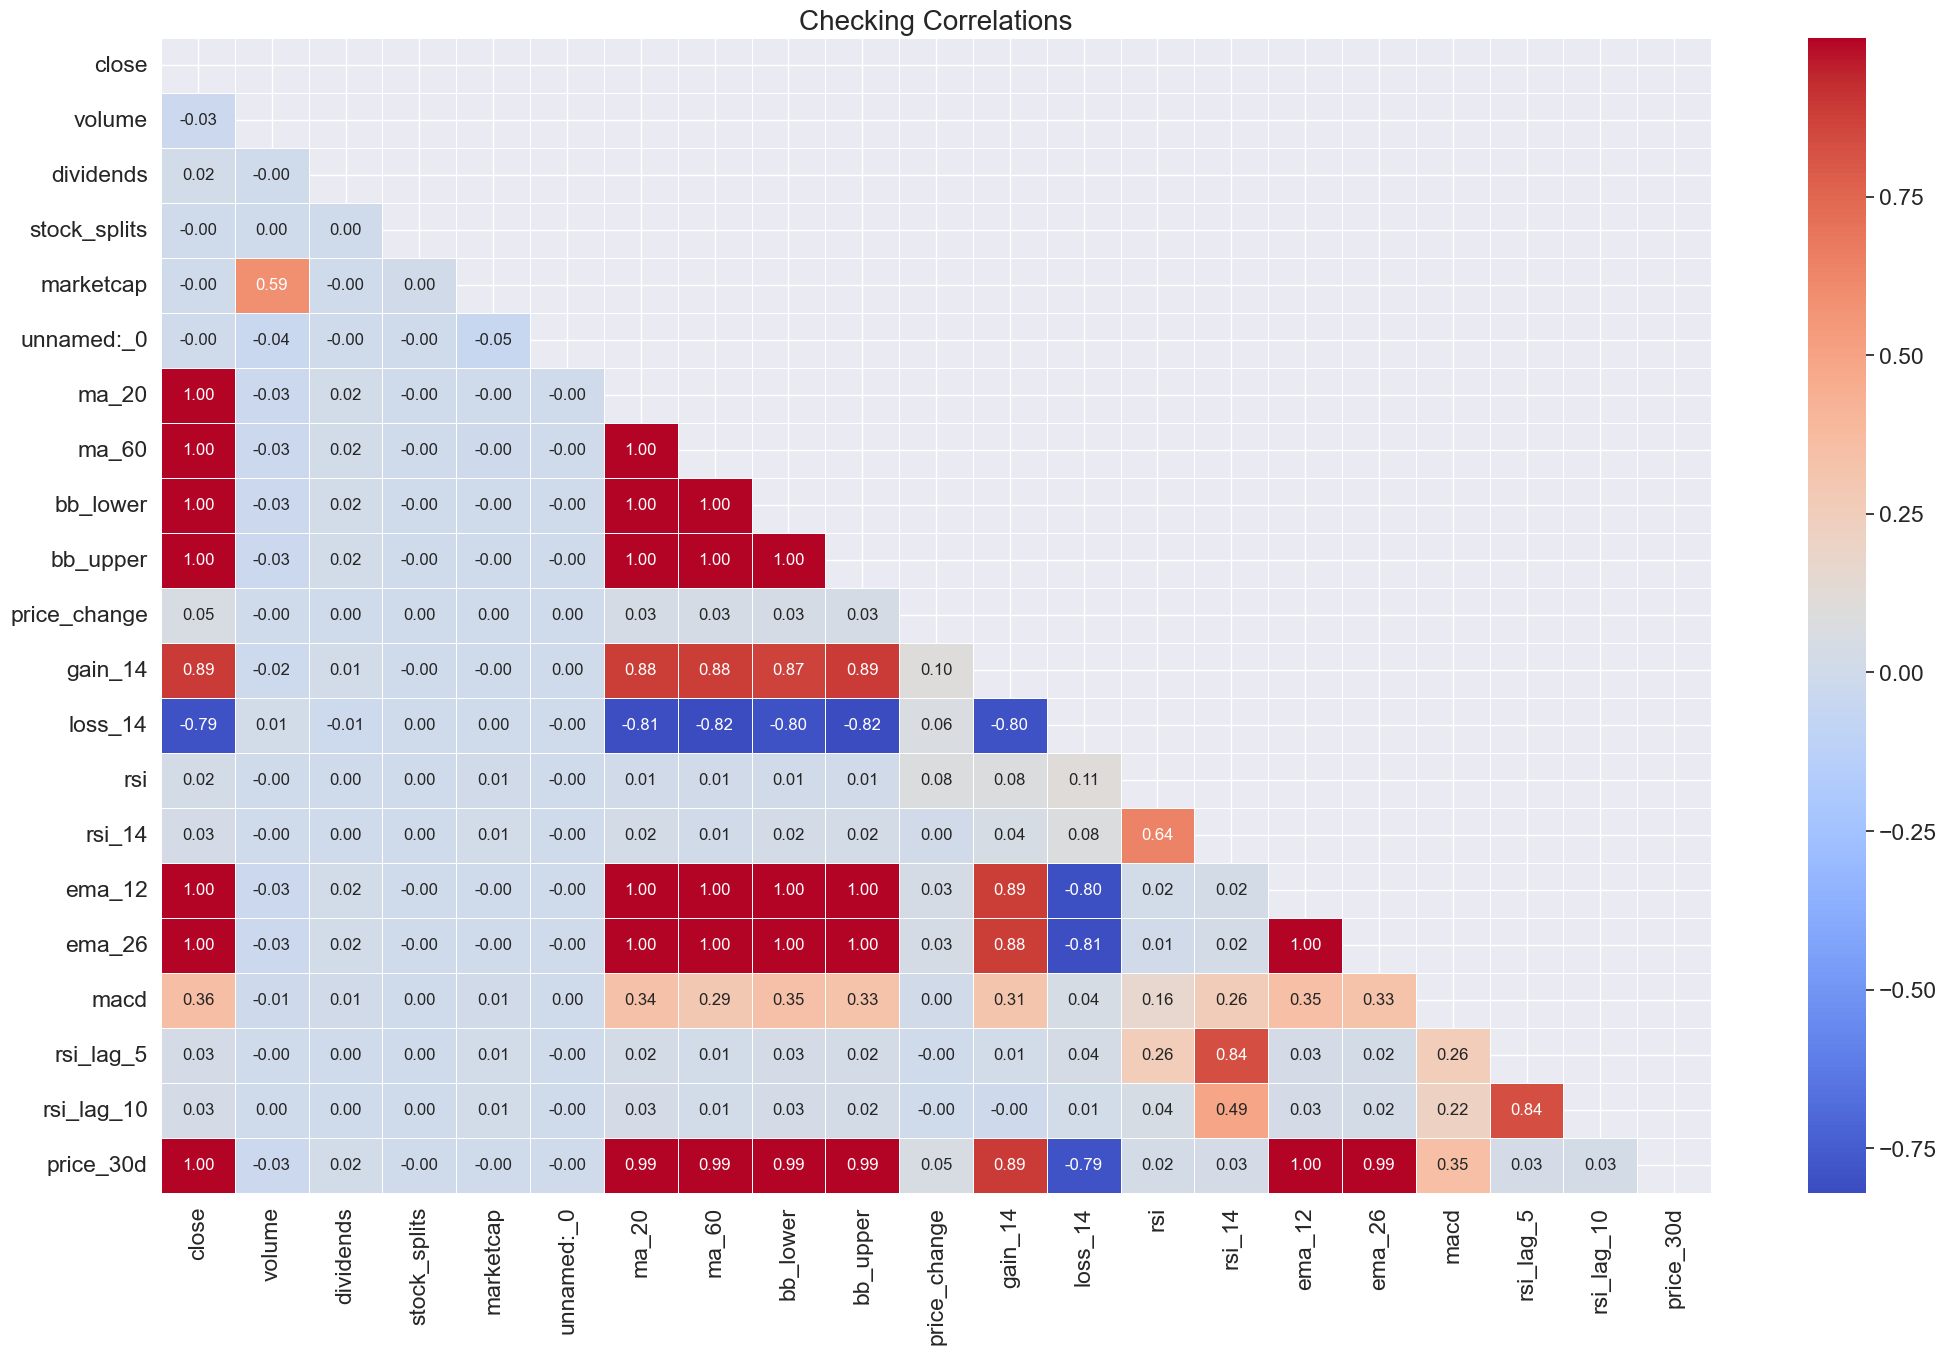

In [7]:
# Correlation Matrix-Heatmap Plot
num = df4.select_dtypes("number")
correlation_matrix = num.corr()

mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5) # increase font size
ax = sns.heatmap(correlation_matrix, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Checking Correlations", fontsize=20) # add title

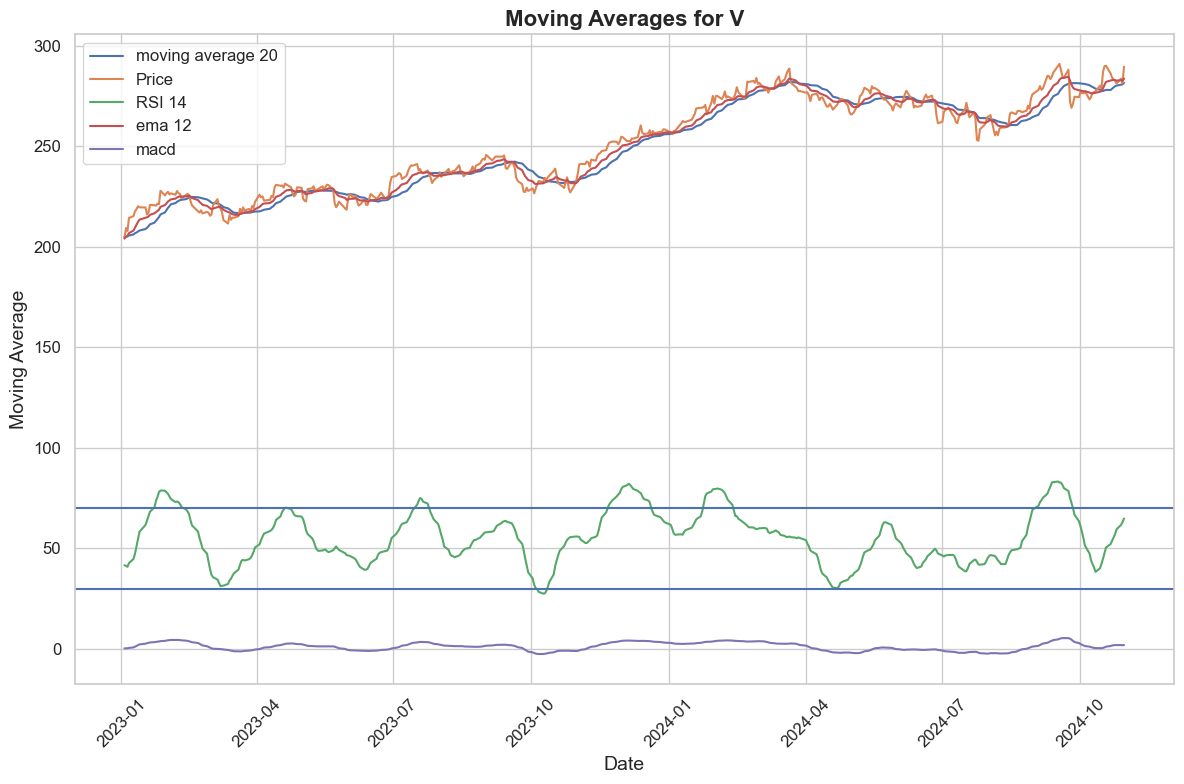

In [8]:
# plotting for test

co = "V"

df3 = df4.copy()
df3.reset_index(inplace=True)
df3["date"] = pd.to_datetime(df3["date"])
df3.set_index("date", inplace=True)
df3.sort_index(inplace=True)
df3 = df3.loc["2023":]

plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

#sns.lineplot(data=df3[df3["company"] == co], x="date", y="bb_lower", label="10")
sns.lineplot(data=df3[df3["company"] == co], x="date", y="ma_20", label="moving average 20")
#sns.lineplot(data=df3[df3["company"] == co], x="date", y="bb_upper", label="30")
#sns.lineplot(data=df3[df3["company"] == co], x="date", y="rsi", label="RSI")
sns.lineplot(data=df3[df3["company"] == co], x="date", y="close", label="Price")
sns.lineplot(data=df3[df3["company"] == co], x="date", y="rsi_14", label="RSI 14")
#sns.lineplot(data=df3[df3["company"] == co], x="date", y="price_30d", label="Price 30d")
sns.lineplot(data=df3[df3["company"] == co], x="date", y="ema_12", label="ema 12")
sns.lineplot(data=df3[df3["company"] == co], x="date", y="macd", label="macd")

plt.axhline(y=70)
plt.axhline(y=30)

plt.title(f'Moving Averages for {co}', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Moving Average', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12, loc='best')
plt.tight_layout()

## XGBoost Metrics

In [9]:
dict_2022 = {
"jan": "2022-01-03", 
"feb": "2022-02-01", 
"mar": "2022-03-01", 
"apr": "2022-04-01", 
"may": "2022-05-03", 
"june": "2022-06-01", 
"july": "2022-07-01", 
"aug": "2022-08-01", 
"sep": "2022-09-01", 
"oct": "2022-10-03", 
"nov": "2022-11-01", 
"dec": "2022-12-01"
}

In [10]:
dict_2023 = {
"jan": "2023-01-03", 
"feb": "2023-02-01", 
"mar": "2023-03-01", 
"apr": "2023-04-03", 
"may": "2023-05-03", 
"june": "2023-06-01", 
"july": "2023-07-03", 
"aug": "2023-08-01", 
"sep": "2023-09-01", 
"oct": "2023-10-03", 
"nov": "2023-11-01", 
"dec": "2023-12-01"
}

In [11]:
dict_2024 = {
"jan": "2024-01-02", 
"feb": "2024-02-01", 
"mar": "2024-03-01", 
"apr": "2024-04-03", 
"may": "2024-05-03", 
"june": "2024-06-03", 
"july": "2024-07-01", 
"aug": "2024-08-01", 
"sep": "2024-09-03"
}

In [12]:
xgbr_2022 = XGB_train(2021)
model_test(2022, xgbr_2022)
df3 = get_gains(dict_2022, xgbr_2022)
print(f"if invested according predictions, profit of 2022 would be: {df3['gain'].sum().round()} %")

R2 =  0.6698
RMSE =  152.843
MSE =  23360.9736
MAE =  24.8375
if invested according predictions, profit of 2022 would be: -25.0 %


In [13]:
xgbr_2023 = XGB_train(2022)
model_test(2023, xgbr_2023)
df1 = get_gains(dict_2023, xgbr_2023)
print(f"if invested according predictions, profit of 2023 would be: {df1['gain'].sum().round()} %")

R2 =  0.5949
RMSE =  221.9839
MSE =  49276.8556
MAE =  30.9704
if invested according predictions, profit of 2023 would be: 53.0 %


In [14]:
xgbr_2024 = XGB_train(2024)
model_test(2024, xgbr_2024)
df2 = get_gains(dict_2024, xgbr_2024)
print(f"if invested according predictions, profit of 2024 would be: {df2['gain'].sum().round()} %")

R2 =  0.5542
RMSE =  312.2976
MSE =  97529.8209
MAE =  40.8693
if invested according predictions, profit of 2024 would be: 36.0 %


## Preprocessing for Keras

In [15]:
# import data
df5 = pd.read_csv("ml1.csv")
#df5.drop(columns=["company.1"], inplace=True)

# short cleaning
df5.set_index("date", inplace=True)
df5.sort_index(inplace=True)

In [16]:
df5["company"] = df5["company"].astype("category")
df5["company"] = df5["company"].cat.codes
df5["sector"] = df5["sector"].astype("category")
df5["sector"] = df5["sector"].cat.codes
df5["subsector"] = df5["subsector"].astype("category")
df5["subsector"] = df5["subsector"].cat.codes

In [17]:
# create training and test data
training = df5.loc[:"2023"]
test = df5.loc["2023":]

X_training = training.drop(columns="price_30d")
X_test = test.drop(columns="price_30d")
y_training = training["price_30d"]
y_test = test["price_30d"]


In [18]:
# separate categorical features
company_training = X_training["company"]
category_training = X_training["sector"]
subcategory_training = X_training["subsector"]
X_training.drop(columns=["company", "sector", "subsector"], inplace=True)

company_test = X_test["company"]
category_test = X_test["sector"]
subcategory_test = X_test["subsector"]
X_test.drop(columns=["company", "sector", "subsector"], inplace=True)


In [19]:
scaler = MinMaxScaler()
X_training_scaled = scaler.fit_transform(X_training)
X_test_scaled = scaler.fit_transform(X_test)

### About Keras
#### General
- high level python library built on top of TensorFlow
- to create deep learning models

#### Building Components
- Build sequential model
- Dense layer: basic building block
- LSTM layer: predict whats next
- Embedding: turns categories into numbers, instead of one-hot encoding
- Loss function using MSE --> number should go down
- Optimizers: SGD, Adam, RMSprop


In [20]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Embedding, Flatten, Concatenate
from keras.layers import Dropout

#### Embedding Layer
- one embedding layer for each categorical
- should be ordinal encoded already
- number of dimensions: zb 10, 50, 100, 300

In [21]:
# create model
model = Sequential()

In [22]:
df5["subsector"].nunique()

126

In [23]:
# numerical input
num_input = Input(shape=(X_training_scaled.shape[1],))

# categorical input
company_input = Input(shape=(1,))
embedding_1 = Embedding(input_dim=499, output_dim=5)(company_input)
embedding_flatten_1 = Flatten()(embedding_1)

sector_input = Input(shape=(1,))
embedding_2 = Embedding(input_dim=11, output_dim=5)(sector_input)
embedding_flatten_2 = Flatten()(embedding_2)

subsector_input = Input(shape=(1,))
embedding_3 = Embedding(input_dim=126, output_dim=5)(subsector_input)
embedding_flatten_3 = Flatten()(embedding_3)

# combine inputs
combined = Concatenate()([num_input, embedding_flatten_1, embedding_flatten_2, embedding_flatten_3])

In [24]:
# dense layers
x = Dense(64, activation="relu")(combined)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
output = Dense(1)(x)

In [25]:
# compile model
model = Model(inputs=[num_input, company_input, sector_input, subsector_input], outputs=output)
model.compile(optimizer="adam", loss="mse")

In [26]:
# train model
#model.fit([X_training, company_training, category_training, subcategory_training], y_training, validation_data=([X_test, company_test, category_test, subcategory_test], y_test), epochs=50, batch_size=32)

In [27]:
# save model
from keras.models import load_model

#model = create_and_train_model()

#model.save('model_1.h5')

In [28]:
# evaluation
test_loss = model.evaluate([X_test_scaled, company_test, category_test, subcategory_test], y_test)
test_loss

7123/7123 ━━━━━━━━━━━━━━━━━━━━ 3s 459us/step - loss: 152993.2969


201979.171875

In [29]:
#predictions 2023

dict_2023 = {
"jan": "2023-01-03", 
"feb": "2023-02-01", 
"mar": "2023-03-01", 
"apr": "2023-04-03", 
"may": "2023-05-03", 
"june": "2023-06-01", 
"july": "2023-07-03", 
"aug": "2023-08-01", 
"sep": "2023-09-01", 
"oct": "2023-10-03", 
"nov": "2023-11-01", 
"dec": "2023-12-01"
}

kgains_2023_df = pd.DataFrame(columns=["month", "gain"])
for k, v in dict_2023.items():
    keras_df_2023 = df5.loc[v]


    # create training and test data
    training = df5.loc[:"2023"]
    test = df5.loc[v]

    X_training = training.drop(columns="price_30d")
    X_test = test.drop(columns="price_30d")
    y_training = training["price_30d"]
    y_test = test["price_30d"]



    # separate categorical features
    company_training = X_training["company"]
    category_training = X_training["sector"]
    subcategory_training = X_training["subsector"]
    X_training.drop(columns=["company", "sector", "subsector"], inplace=True)

    company_test = X_test["company"]
    category_test = X_test["sector"]
    subcategory_test = X_test["subsector"]
    X_test.drop(columns=["company", "sector", "subsector"], inplace=True)



    scaler = MinMaxScaler()
    X_training_scaled = scaler.fit_transform(X_training)
    X_test_scaled = scaler.fit_transform(X_test)



    

    k_predictions_2023 = model.predict([X_test_scaled, company_test, category_test, subcategory_test])
    ktest_2023 = keras_df_2023[["close", "price_30d"]]
    ktest_2023["prediction"] = k_predictions_2023
    ktest_2023["gain_predicted"] = (ktest_2023["prediction"] - ktest_2023["close"]) / ktest_2023["close"] * 100
    ktest_2023["gain_real"] = (ktest_2023["price_30d"] - ktest_2023["close"]) / ktest_2023["close"] * 100

    ktest_2023.sort_values(by="gain_predicted", ascending=False, inplace=True)
    kgain = ktest_2023.head(10)["gain_real"].mean()

    kmy_df_2023 = pd.DataFrame({"month": [k], "gain": [kgain]})

    kgains_2023_df = pd.concat([kgains_2023_df, kmy_df_2023], ignore_index=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [30]:
ktest_2023.head(10)

,close,price_30d,prediction,gain_predicted,gain_real
date,,,,,
2023-12-01,3131.792236,3459.229004,-0.207603,-100.006629,10.455252
2023-12-01,1127.709961,1230.160034,-0.095412,-100.008461,9.084789
2023-12-01,1104.469971,1163.000000,-0.096033,-100.008695,5.299377
2023-12-01,918.990479,977.221191,-0.085436,-100.009297,6.336378
2023-12-01,6320.350098,7104.600098,-0.599340,-100.009483,12.408332
2023-12-01,2641.750000,2669.209961,-0.277537,-100.010506,1.039461
2023-12-01,980.520020,992.159973,-0.116969,-100.011929,1.187120
2023-12-01,797.234985,832.454651,-0.097396,-100.012217,4.417727
2023-12-01,612.469971,596.099976,-0.092445,-100.015094,-2.672783


In [31]:
kgains_2023_df

,month,gain
0,jan,10.859395
1,feb,-5.225018
2,mar,4.902898
3,apr,-0.103658
4,may,2.678728
5,june,10.048779
6,july,4.787826
7,aug,-3.576402
8,sep,-2.280921
9,oct,9.724361


In [32]:
print(f"if invested according predictions, profit of 2023 would be: {kgains_2023_df['gain'].sum().round()} %")

if invested according predictions, profit of 2023 would be: 53.0 %
